# <font color='darkblue'>Setup</font> 

## <font color='orange'>Packages</font> 

In [1]:
# Packages -----------------------------------------------#

# Data Analysis
import xarray as xr
import numpy as np
import pandas as pd
import metpy.calc as mpcalc
import matplotlib.dates as dates
from tqdm import tqdm

# Plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter
from matplotlib.lines import Line2D
import datetime as dt

# make sure the figures plot inline rather than at the end
%matplotlib inline

## <font color='orange'>Parameters</font> 

In [2]:
bounds = [35,120,-20,30] # for all binning
binwidth = 2 # number of degrees for bins

# these are for grouping into IOD peak season and non peak season
IODseason_begin = 8
IODseason_end = 12

# these are for grouping into the IOD years since the effects are 
# not confined to a single year. You chose this to have an even 
# number of months around the IOD peak..but now you left it in
# line with the SLA plots that start in 06 and end in 05
IODyear_begin = '-06-01' # month-day of IOD year
IODyear_end = '-05-31' # month-day of year AFTER IOD year

# # define months to start and end on when sampling
# begin = '-05-01' #iod year
# end = '-04-30'  # post iod year

## <font color='orange'>Functions</font> 

In [3]:
def gaus_filter_nan(img,sigma = 1):
    # import required packages
    from astropy.convolution import convolve
    from astropy.convolution import Gaussian2DKernel
    
    # create a kernal with std = 1
    kernel = Gaussian2DKernel(x_stddev=1)
    
    #convolve that with the 2d matrix
    img_conv = convolve(img, kernel)

    # set original nan points back to nans
    img_conv[np.isnan(img)] = np.nan

    return img_conv

def add_land(ax,bounds= [35,120,-20,30]):
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    ax.add_feature(cfeature.LAND,color='gray',zorder = 0)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution='110m',zorder = 0)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    return None 

def find_coast(arr):
    import itertools
    
    # create empty lists to add row and col info to
    rowind = []
    colind = []

    # create an array of indices
    rows = np.arange(arr.shape[0])
    cols = np.arange(arr.shape[1])

    # find if the sum of a block around a point is a nan (meaning one of the values at least must have been a nan)
    for row,col in itertools.product(rows,cols):
        rowcond = (np.isnan(np.sum(arr[max(0,row-1):min(arr.shape[0],row+2),col])))
        colcond = (np.isnan(np.sum(arr[row,max(0,col-1):min(arr.shape[1],col+2)])))

        if  (~np.isnan(arr[row,col])) & (rowcond | colcond):
            rowind.append(rows[row].tolist())
            colind.append(cols[col].tolist())
    
    return np.array(rowind), np.array(colind)

def order_coast(loninds,latinds,sta_zero):
    # find based on radius
    zipped_lists = zip(loninds, latinds)
    sorted_pairs = sorted(zipped_lists, reverse=True)

    # sort by lon
    tuples = zip(*sorted_pairs)
    lon_list,lat_list  = [ list(tuple) for tuple in  tuples]

    pos = []
    curr_sta = []
    rem_sta = sorted_pairs
    for i in range(len(lon_list)):
#         print(i)
        if i == 0:
            curr_sta.append(sta_zero)
            rem_sta.remove(sta_zero) 
            prev_sta = sta_zero
        else:
            prev_sta = curr_sta[i-1]

        start_len = len(curr_sta)
        dir1 = False
        for j,(lo, la) in enumerate(rem_sta):
            
            next_sta = (rem_sta[j])
            
            diff = tuple(map(lambda l, k: l - k, curr_sta[i], next_sta))
            
            # check uplr first
            if(next_sta != prev_sta) & (all(np.abs(diff) == [0,1])) | (all(np.abs(diff) == [1,0])):
                curr_sta.append(next_sta)
                rem_sta.remove(next_sta) 
                dir1 = True
                break
        if dir1 == False:
            for j,(lo, la) in enumerate(rem_sta):

                next_sta = (rem_sta[j])

                diff = tuple(map(lambda l, k: l - k, curr_sta[i], next_sta))
                # then check diagonals
                if (next_sta != prev_sta) & (all(np.abs(diff) == [1,1])):
                    curr_sta.append(next_sta)
                    rem_sta.remove(next_sta) 
                    break
                
        if len(curr_sta) == start_len:
            print('No Next Station Found. Returning Previous Stations Only.')
            print(curr_sta[i],rem_sta)
            break
        
    sta_lonind, sta_latind  = map(np.array, zip(*curr_sta))
    
    return sta_lonind, sta_latind

# binning for one variable ------------------------------------------------------------#
def latlonbin(invar,lat,lon,bounds,binwidth):
    import numpy as np
    
    # create a pandas dataframe
    df = pd.DataFrame(dict(
            invar = np.array(invar),
            lat= np.array(lat),
            lon= np.array(lon),
        ))

    # create 1 degree bins
    latedges = np.arange(bounds[2]-(binwidth/2),bounds[3]+(binwidth/2),binwidth)
    lat_inds = list(range(len(latedges)-1))

    lonedges = np.arange(bounds[0]-(binwidth/2),bounds[1]+(binwidth/2),binwidth)
    lon_inds = list(range(len(lonedges)-1))

    latbins = latedges[1:]-(binwidth/2)
    lonbins = lonedges[1:]-(binwidth/2)

    df['latedges'] = pd.cut(lat, latedges)
    df['lonedges'] = pd.cut(lon, lonedges)
    df['latbins_ind'] = pd.cut(lat, latedges,labels = lat_inds)
    df['lonbins_ind'] = pd.cut(lon, lonedges,labels = lon_inds)
    df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
    grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

    invar_BINNED = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_BINNED[:] = np.nan

    invar_binned_ave = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_binned_ave[:] = np.nan
    
    invar_bincounts = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_bincounts[:] = np.nan


    #extract the data for each group
    for name, group in grouped:
        i = np.array(group.latbins_ind)
        j = np.array(group.lonbins_ind)

        invar_BINNED[i[0],j[0]] = group.invar

        invar_binned_ave[i[0],j[0]] = np.nanmean(group.invar)   
        
        invar_bincounts[i[0],j[0]] = len(group.invar[np.isfinite(group.invar)]) 

    return np.array(invar_binned_ave,dtype = float),np.array(invar_bincounts,dtype = float),latbins,lonbins

# binning for one variable ------------------------------------------------------------#
def latlonbin_season(invar,lat,lon,season,bounds,binwidth):
    import numpy as np
    
    # create a pandas dataframe
    df = pd.DataFrame(dict(
            invar = np.array(invar),
            lat= np.array(lat),
            lon= np.array(lon),
            season = np.array(season)
        ))

    # create 1 degree bins
    latedges = np.arange(bounds[2]-(binwidth/2),bounds[3]+(binwidth/2),binwidth)
    lat_inds = list(range(len(latedges)-1))

    lonedges = np.arange(bounds[0]-(binwidth/2),bounds[1]+(binwidth/2),binwidth)
    lon_inds = list(range(len(lonedges)-1))

    latbins = latedges[1:]-(binwidth/2)
    lonbins = lonedges[1:]-(binwidth/2)

    df['latedges'] = pd.cut(lat, latedges)
    df['lonedges'] = pd.cut(lon, lonedges)
    df['latbins_ind'] = pd.cut(lat, latedges,labels = lat_inds)
    df['lonbins_ind'] = pd.cut(lon, lonedges,labels = lon_inds)
    df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
    grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

    invar_BINNED = np.zeros((2,len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_BINNED[:] = np.nan

    invar_binned_ave = np.zeros((2,len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_binned_ave[:] = np.nan
    
    invar_bincounts = np.zeros((2,len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_bincounts[:] = np.nan
    
    #extract the data for each group
    for name,group in grouped:
        i = np.array(group.latbins_ind)
        j = np.array(group.lonbins_ind)
        
        #group a second time by IOD Season
        seas_grouped = group.groupby(['season'])
        
        for ss,seas_group in seas_grouped:
#             print(ss,np.array(seas_group.season))

            invar_BINNED[ss,i[0],j[0]] = np.array(seas_group.invar)

            invar_binned_ave[ss,i[0],j[0]] = np.nanmean(seas_group.invar)   

            invar_bincounts[ss,i[0],j[0]] = len(seas_group.invar[np.isfinite(seas_group.invar)]) 


    return (np.array(invar_binned_ave,dtype = float),invar_BINNED,
            np.array(invar_bincounts,dtype = float),latbins,lonbins)

def coastal_blocks_IOD_season_WOA(var,sta_loninds,sta_latinds,loc_list):
    
    no_seasons = var.shape[0]
    data = np.zeros([no_seasons,sta_loninds.shape[0]], dtype=np.ndarray)
    seas_data = np.zeros([2,len(loc_list)-1], dtype=np.ndarray) # 1 less because averaages between edges
    
    for ss in range(no_seasons):
        for jj in range(sta_loninds.shape[0]):
            data[ss,jj] = np.array(var[ss,sta_latinds[jj],sta_loninds[jj]])

        for ll in range(len(loc_list)-1):
            for mm in range(loc_list[ll+1]-loc_list[ll]):
                if mm == 0:
                    tup  = data[ss,loc_list[mm]]
                else:
                    tup = np.hstack((tup,data[ss,loc_list[ll]+mm]))

            seas_data[ss,ll] = tup
            
    return seas_data

def IOD_year_group(invar,inlat,inlon,intime,inseason,begin,end,IODyears):
    data= []
    lat = []
    lon = []
    time = []
    season = []
    for ii,year in enumerate(IODyears):
        start_time = str(year) + begin
        end_time = str(year+1) + end
        time_slice = slice(start_time, end_time)
#         print(time_slice)
        data.extend(np.array(invar.sel(time=time_slice)))
        lat.extend(np.array(inlat.sel(time=time_slice)))
        lon.extend(np.array(inlon.sel(time=time_slice)))
        time.extend(np.array(intime.sel(time=time_slice)))
        season.extend(np.array(inseason.sel(time=time_slice)))
        
    return data,lat,lon,time,season

def coastal_block_IOD_season_phase(phase_list,sta_loninds,sta_latinds,loc_list):
    
    temp_phase_data = np.zeros(len(phase_list), dtype=np.ndarray)
    no_seasons = phase_list[0].shape[0]
    
    for pp,phase in enumerate(phase_list):
        
        data = np.zeros([no_seasons,sta_loninds.shape[0]], dtype=np.ndarray)
        block_data = np.zeros([no_seasons,len(loc_list)-1], dtype=np.ndarray)
        
        for ss in range(no_seasons):
            for jj in range(sta_loninds.shape[0]):
                data[ss,jj] = np.array(phase[ss,sta_latinds[jj],sta_loninds[jj]])

            for ll in range(len(loc_list)-1):
                for mm in range(loc_list[ll+1]-loc_list[ll]):
                    if mm == 0:
                        tup  = data[ss,loc_list[mm]]
                    else:
                        tup = np.hstack((tup,data[ss,loc_list[ll]+mm]))

                block_data[ss,ll] = tup
                
        temp_phase_data[pp] = block_data
        
    return temp_phase_data

## <font color='orange'>Read Data</font> 

In [4]:
ds_CD = xr.open_dataset('../data/CD/CD.nc')
# ds_CD

## <font color='orange'>Find Coastlines</font> 

### <font color='lightblue'>Unordered</font> 

In [5]:
# ------------------------------------------------------------#
# Only take data after 1994 to make sure your bins are close to 
# to the coast but also have enough data to make the pdfs
# ------------------------------------------------------------#
start_time = '1994-01-01'
end_time = '2020-02-07'
time_slice = slice(start_time, end_time)

TCD = ds_CD.TCD_AWG.sel(time=time_slice)
OCD = ds_CD.OCD_AWG.sel(time=time_slice)
lat = ds_CD.lat.sel(time=time_slice)
lon = ds_CD.lon.sel(time=time_slice)

TCD_binned_ave,TCD_bncts,latbins,lonbins = latlonbin(TCD,lat,lon,bounds,binwidth)

# ------------------------------------------------------------#
# block out a few places that you don't want to include
# ------------------------------------------------------------#

mask = TCD_binned_ave
xx,yy = np.meshgrid(lonbins,latbins)

# set Gulfs to Nans
mask = np.where(~((yy>22) & (xx<60)),mask,np.nan)
mask = np.where(~((yy>10) & (xx<51)),mask,np.nan)

# AS inlets
mask = np.where(~((yy>21.5) & (yy<22) & (xx>72) & (xx<73)),mask,np.nan)
mask = np.where(~((yy>22.25) & (yy<22) & (xx>69) & (xx<70.5)),mask,np.nan)
mask = np.where(~((yy>23.25) & (yy<22) & (xx>69) & (xx<70)),mask,np.nan)

# Sumatra area

mask = np.where(~((yy>-2) & (yy<1) & (xx>97) & (xx<101)),mask,np.nan)

# equator
mask = np.where(~(yy<0),mask,np.nan)

# ------------------------------------------------------------#
# locate points along the BoB and AS
# ------------------------------------------------------------#

sta_latinds_unord, sta_loninds_unord = find_coast(np.array(mask))

# ------------------------------------------------------------#
# Remove Manually some other points
# ------------------------------------------------------------#

sta_latinds_unord = sta_latinds_unord[9:]
sta_loninds_unord = sta_loninds_unord[9:]

# AS
lons_from_sta = np.array(lonbins[sta_loninds_unord])
lats_from_sta = np.array(latbins[sta_latinds_unord])

ind = ~((lons_from_sta <52) & (lats_from_sta < 15))
sta_latinds_unord = sta_latinds_unord[ind]
sta_loninds_unord = sta_loninds_unord[ind]

#BoB
lons_from_sta = np.array(lonbins[sta_loninds_unord])
lats_from_sta = np.array(latbins[sta_latinds_unord])

ind = ~((lons_from_sta >99))
sta_latinds_unord = sta_latinds_unord[ind]
sta_loninds_unord = sta_loninds_unord[ind]

# ------------------------------------------------------------#
# Plot
# ------------------------------------------------------------#

# bounds = [40,100,-5,30]

# cmin = -0.2
# cmax = 0.2
# levels = np.linspace(cmin, cmax, 10)

# # Start figure
# fig = plt.figure(figsize=(16, 8))
# ax = plt.axes(projection=ccrs.PlateCarree())
# add_land(ax,bounds)
# xx,yy = np.meshgrid(lonbins,latbins)
# xx = xx.flatten()
# yy = yy.flatten()
# p2 = plt.scatter(xx,yy,c = TCD_binned_ave.flatten(),marker='s',
#                       s = 500,cmap=plt.cm.Spectral,vmin=20,vmax=160,transform=ccrs.PlateCarree())
# # cf = ax.contourf(lon, lat,sla_mon_anom[0,:,:],levels = levels,cmap=plt.cm.PuOr_r, extend="both")
# plt.scatter(lonbins[sta_loninds_unord],latbins[sta_latinds_unord],
#             s = 160,c=np.arange(len(sta_latinds_unord)),marker = '.',cmap =plt.cm.PiYG)
# plt.colorbar(label = 'Station No.')
# plt.title('Unordered Stations')

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:156: RuntimeWarning: Mean of empty slice


### <font color='lightblue'>Ordered</font> 

No Next Station Found. Returning Previous Stations Only.
(13, 23) [(12, 21), (12, 20), (11, 19), (10, 19), (9, 18), (8, 18)]


Text(0.5, 1.0, 'Stations')

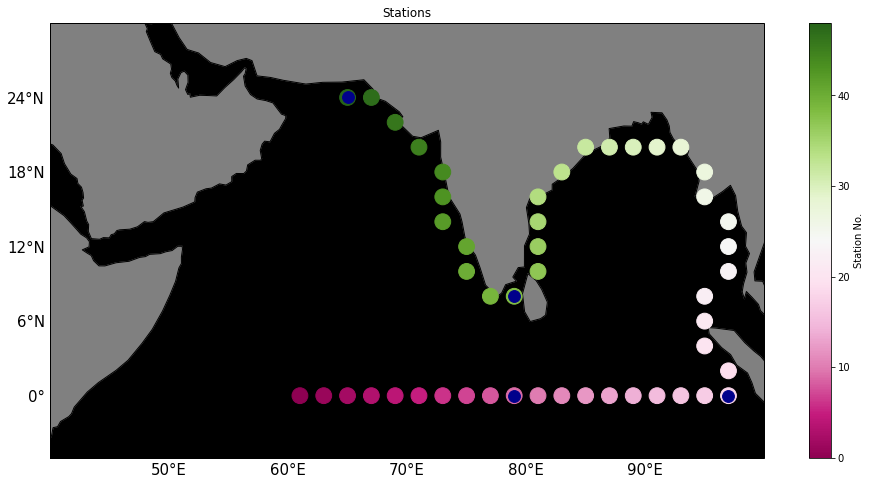

In [6]:
# ------------------------------------------------------------#
# put in the right order
# ------------------------------------------------------------#

#initial station
sta_zero = (sta_loninds_unord[0],sta_latinds_unord[0]) # 98.625, 10.375

#calculate
sta_loninds, sta_latinds =order_coast(sta_loninds_unord,sta_latinds_unord,sta_zero)

sta_latinds = sta_latinds[:-3]
sta_loninds = sta_loninds[:-3]

# ------------------------------------------------------------#
# identify initial stations to demarcate 
# stations for EQ, BOB, and AS
# ------------------------------------------------------------#

# EQ = 0
JA = 9
sBoB = 18
# mBoB = 65
SL = 38
mAS = 48
# eAS = 90
loc_list = [JA,sBoB,SL,mAS]

# ------------------------------------------------------------#
# plot
# ------------------------------------------------------------#
cbounds = [40,100,-5,30]
    
cmin = -0.2
cmax = 0.2
levels = np.linspace(cmin, cmax, 10)

# Start figure
fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
add_land(ax,cbounds)
xx,yy = np.meshgrid(lonbins,latbins)
# xx = xx.flatten()
# yy = yy.flatten()
# plt.pcolormesh(xx,yy,TCD_binned_ave)
# p2 = plt.scatter(xx,yy,c = TCD_binned_ave.flatten(),marker='s',
#                       s = 500,cmap=plt.cm.Spectral,vmin=20,vmax=160,transform=ccrs.PlateCarree())
p =plt.scatter(lonbins[sta_loninds],latbins[sta_latinds],
            s = 1000,c=np.arange(len(sta_latinds)),marker = '.',cmap =plt.cm.PiYG)

plt.scatter(lonbins[sta_loninds[loc_list]],latbins[sta_latinds[loc_list]],
            s = 560,c='darkblue',marker = '.')
plt.colorbar(p,label = 'Station No.')

plt.title('Stations')

# plt.savefig('../figures/stations-SLA-along-coast.png', dpi=300, bbox_inches='tight')

## <font color='orange'>Find Seasons</font> 

In [7]:
month = ds_CD.time.dt.month
month = np.array(month)
IODseason = np.full(month.shape,1)

# ------------------------------------------------------------#
# Based on IOD peak, SON
# ------------------------------------------------------------#
if IODseason_end < IODseason_begin:
    IODseason = np.where((month >= IODseason_begin) | (month <= IODseason_end),IODseason,0)
else:
    IODseason = np.where((month >= IODseason_begin) & (month <= IODseason_end),IODseason,0)

# add to dataset
ds_CD['IODseason'] = xr.DataArray(IODseason,dims = ['time'],coords =[ds_CD.time])

In [8]:
month[200:300]

array([ 2,  2, 11,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  4,  4,  5,
        5,  5,  5,  5,  7,  7,  7,  7,  7,  8,  8,  8,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9, 10, 10, 10, 10, 11, 11, 11, 11,  4,  5,  6,  6,
        6,  6,  7,  7,  8,  8,  2,  4,  5,  5,  5,  5,  5,  5,  5,  5,  9,
       10, 10,  2,  2,  2,  2,  2,  2,  2,  5,  4,  8, 11,  2,  5,  2,  2,
        2,  2,  2,  5,  5,  5,  5,  5,  8,  8,  8,  8,  8, 11, 11])

In [9]:
IODseason[200:300]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1])

## <font color='orange'>Get IOD Phases</font> 

In [10]:
# load DMI data
ds_DMI= xr.open_dataset('../data/DMI/dmi_processed.nc')
ds_DMI

posIODyears = list(np.array(ds_DMI.pos_IOD_years))
negIODyears = list(np.array(ds_DMI.neg_IOD_years))
neuIODyears = list(np.array(ds_DMI.neu_IOD_years)) 

## <font color='orange'>Group Mean Temperature by IOD Phases</font> 

### <font color='lightblue'>WOA Temperature</font> 

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:213: RuntimeWarning: Mean of empty slice


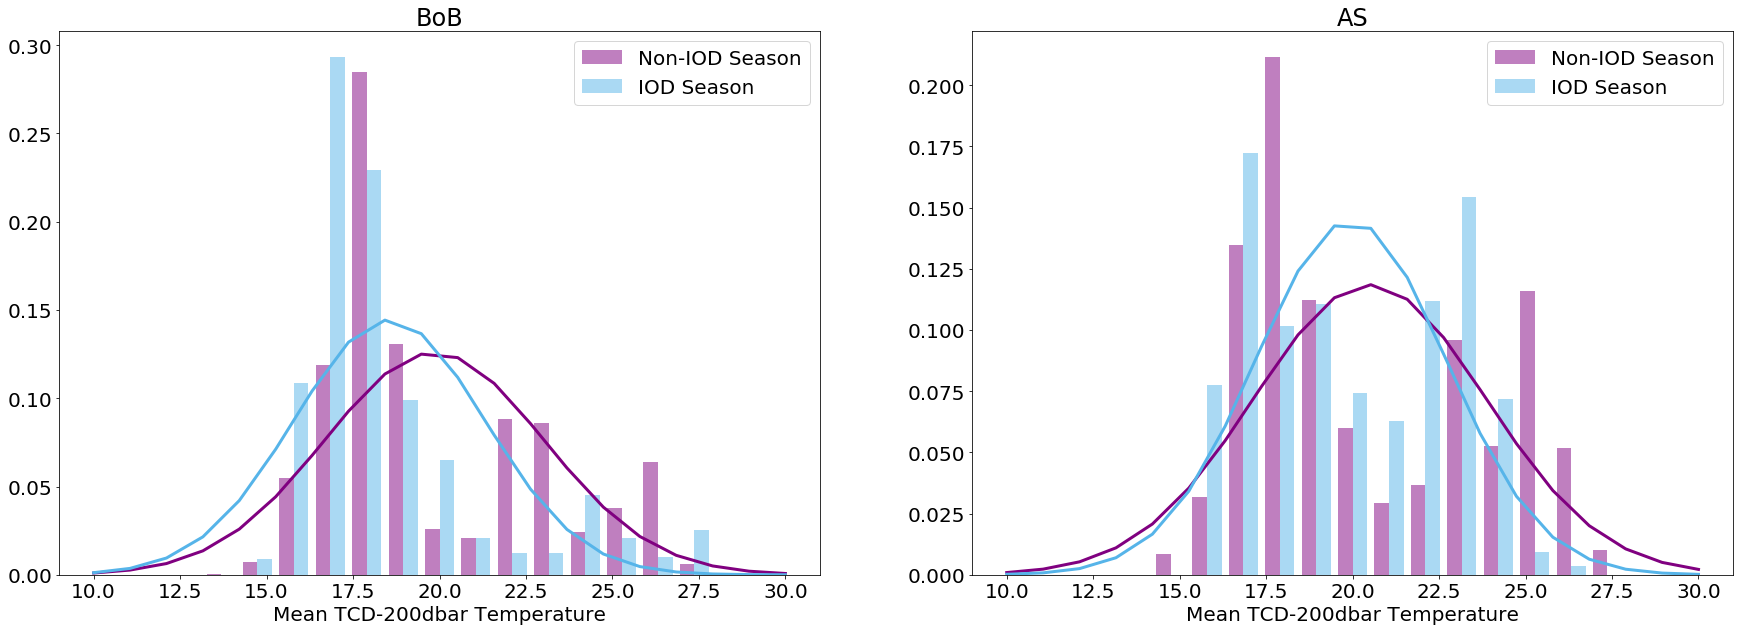

In [21]:
var = ds_CD.temp_WOA_TCD_200_ave
# ------------------------------------------------------------#
# Bin and Block
# ------------------------------------------------------------#
    
# bin for each month
TCD_WOA_bin_ave,TCD_WOA_bin_vals,TCD_WOA_bncts,latbins,lonbins = latlonbin_season(var,
                                                                                  ds_CD.lat,ds_CD.lon,
                                                                                  ds_CD.IODseason,bounds,2)

        
seas_data = coastal_blocks_IOD_season_WOA(TCD_WOA_bin_vals,sta_loninds,sta_latinds,loc_list)

# ------------------------------------------------------------#
# Plot
# ------------------------------------------------------------#

cnt = 1
seas_title = ['EQ', 'BoB', 'AS']
fig = plt.figure(figsize=(30, 10))
plt.rcParams.update({'font.size': 20})
binedges = np.linspace(10,30,20)
for loc in range(1,3):
    # Make a separate list for each airline
    x1 = list(seas_data[0,loc])
    x2 = list(seas_data[1,loc])

    # Assign colors for each airline and the names
    colors = ['purple','#56B4E9']
    names = ['Non-IOD Season','IOD Season']

    ax = fig.add_subplot(1,2,cnt)
    n, bins, patches = plt.hist([x1, x2],bins = binedges,
             density = True,alpha = 0.5,
             color = colors, label=names)
    for ii,x in enumerate([x1,x2]):
        mu = np.nanmean(x)
        sigma = np.nanstd(x)
        y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
         np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
        plt.plot(bins, y, '-',c = colors[ii],linewidth = 3)

    # Plot formatting
    plt.xlabel('Mean TCD-200dbar Temperature')
#     plt.ylim(0,0.25)
    plt.title(seas_title[loc])
    plt.legend()
    cnt = cnt + 1

### <font color='lightblue'>Temperature Anomaly</font> 

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:213: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:213: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:213: RuntimeWarning: Mean of empty slice


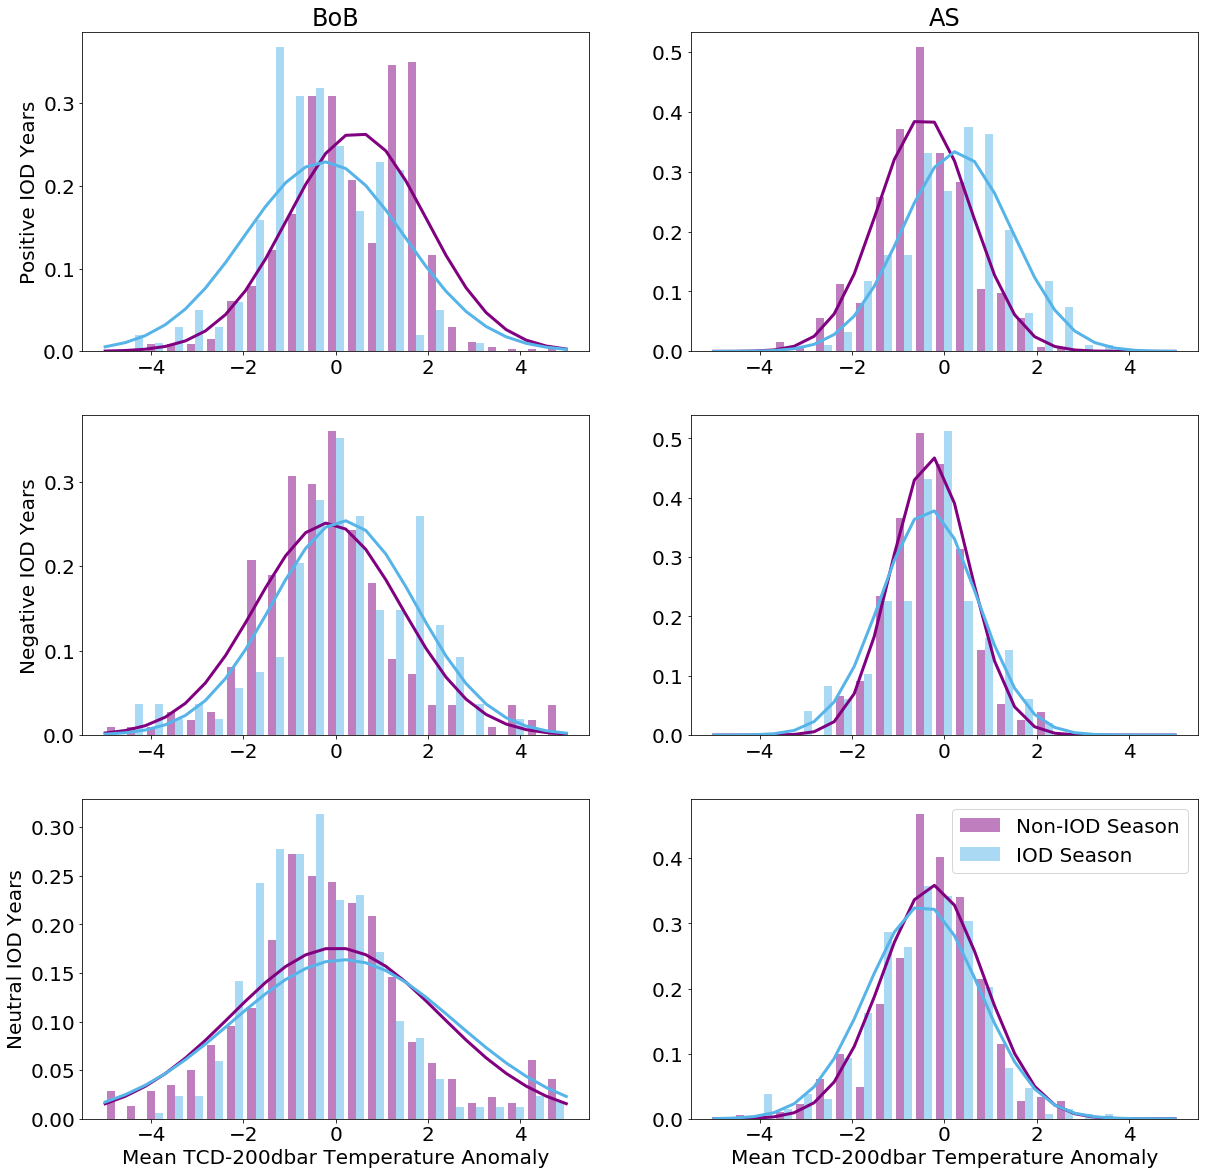

In [22]:
var = ds_CD.temp_anom_TCD_200_ave
# ------------------------------------------------------------#
# Bin
# ------------------------------------------------------------#
    
# average over the positive IOD years -------------------------------------------# 
posIODdata,posIODlat,posIODlon,posIODtime,posIODseason = IOD_year_group(var,
                                             ds_CD.lat,ds_CD.lon,ds_CD.time,
                                             ds_CD.IODseason,IODyear_begin,IODyear_end,posIODyears)
    
# bin for each month
posIOD_TCD_bin_ave,posIOD_TCD_bin_vals,posIOD_TCD_bncts,latbins,lonbins = latlonbin_season(posIODdata,
                                                                                           posIODlat,posIODlon,
                                                                                           posIODseason,
                                                                                           bounds,binwidth)
# average over the negative IOD years -------------------------------------------# 
negIODdata,negIODlat,negIODlon,negIODtime,negIODseason = IOD_year_group(var,
                                             ds_CD.lat,ds_CD.lon,ds_CD.time,
                                             ds_CD.IODseason,IODyear_begin,IODyear_end,negIODyears)
    
# bin for each month
negIOD_TCD_bin_ave,negIOD_TCD_bin_vals,negIOD_TCD_bncts,latbins,lonbins = latlonbin_season(negIODdata,
                                                                                           negIODlat,negIODlon,
                                                                                           negIODseason,
                                                                                           bounds,binwidth)
# average over the neutral IOD years -------------------------------------------# 
neuIODdata,neuIODlat,neuIODlon,neuIODtime,neuIODseason = IOD_year_group(var,
                                             ds_CD.lat,ds_CD.lon,ds_CD.time,
                                             ds_CD.IODseason,IODyear_begin,IODyear_end,neuIODyears)
    
# bin for each month
neuIOD_TCD_bin_ave,neuIOD_TCD_bin_vals,neuIOD_TCD_bncts,latbins,lonbins = latlonbin_season(neuIODdata,
                                                                                           neuIODlat,neuIODlon,
                                                                                           neuIODseason,
                                                                                           bounds,binwidth)

# ------------------------------------------------------------#
# Block
# ------------------------------------------------------------#
phase_list = [posIOD_TCD_bin_vals,negIOD_TCD_bin_vals,neuIOD_TCD_bin_vals]

phase_data = coastal_block_IOD_season_phase(phase_list,sta_loninds,sta_latinds,loc_list)

# ------------------------------------------------------------#
# Plot
# ------------------------------------------------------------#
cnt = 1
phase_title = ['Positive IOD Years','Negative IOD Years','Neutral IOD Years']
seas_title = ['EQ','BoB', 'AS']
fig = plt.figure(figsize=(20, 20))
plt.rcParams.update({'font.size': 20})
binedges = np.linspace(-5,5,24)
for pp in range(3):

    for loc in range(1,3):
        # Make a separate list for each airline
        x1 = list(phase_data[pp][0,loc])
        x2 = list(phase_data[pp][1,loc])

        # Assign colors for each airline and the names
        colors = ['purple', '#56B4E9']
        names = ['Non-IOD Season','IOD Season']

        # Make the histogram using a list of lists
        # Normalize the flights and assign colors and names
        ax = fig.add_subplot(3,2,cnt)
        n, bins, patches = plt.hist([x1, x2],bins = binedges,
                 density = True,alpha = 0.5,
                 color = colors, label=names)
        for ii,x in enumerate([x1,x2]):
            mu = np.nanmean(x)
            sigma = np.nanstd(x)
            y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
             np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
            plt.plot(bins, y, '-',c = colors[ii],linewidth = 3)

        # Plot formatting
        if (cnt == 5) | (cnt ==6):
            plt.xlabel('Mean TCD-200dbar Temperature Anomaly')
        if (cnt == 1) | (cnt ==3)| (cnt ==5):
            plt.ylabel(phase_title[pp])
#         plt.ylim(0,0.02)
#         plt.xlim(0,200)
        if (cnt == 1) | (cnt ==2):
            plt.title(seas_title[loc])
        if cnt == 6:
            plt.legend()
        cnt = cnt + 1

### <font color='lightblue'>Total Temperature and WOA</font> 

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:213: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:213: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:213: RuntimeWarning: Mean of empty slice


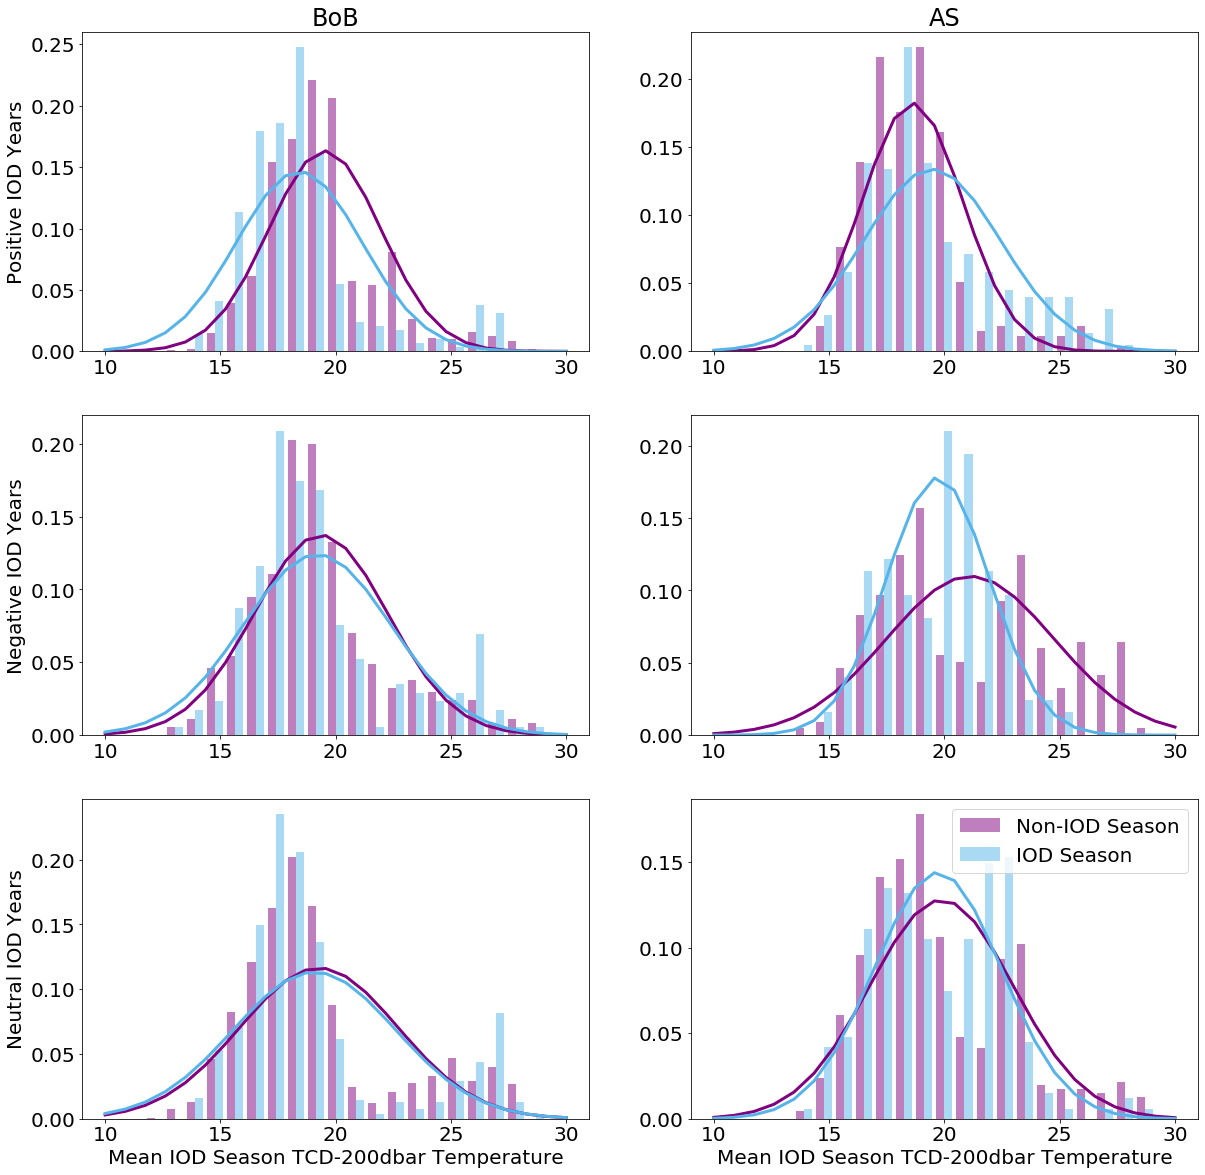

In [28]:
var = ds_CD.temp_TCD_200_ave
# ------------------------------------------------------------#
# Bin
# ------------------------------------------------------------#
    
# average over the positive IOD years -------------------------------------------# 
posIODdata,posIODlat,posIODlon,posIODtime,posIODseason = IOD_year_group(var,
                                             ds_CD.lat,ds_CD.lon,ds_CD.time,
                                             ds_CD.IODseason,IODyear_begin,IODyear_end,posIODyears)
    
# bin for each month
posIOD_TCD_bin_ave,posIOD_TCD_bin_vals,posIOD_TCD_bncts,latbins,lonbins = latlonbin_season(posIODdata,
                                                                                           posIODlat,posIODlon,
                                                                                           posIODseason,
                                                                                           bounds,binwidth)
# average over the negative IOD years -------------------------------------------# 
negIODdata,negIODlat,negIODlon,negIODtime,negIODseason = IOD_year_group(var,
                                             ds_CD.lat,ds_CD.lon,ds_CD.time,
                                             ds_CD.IODseason,IODyear_begin,IODyear_end,negIODyears)
    
# bin for each month
negIOD_TCD_bin_ave,negIOD_TCD_bin_vals,negIOD_TCD_bncts,latbins,lonbins = latlonbin_season(negIODdata,
                                                                                           negIODlat,negIODlon,
                                                                                           negIODseason,
                                                                                           bounds,binwidth)
# average over the neutral IOD years -------------------------------------------# 
neuIODdata,neuIODlat,neuIODlon,neuIODtime,neuIODseason = IOD_year_group(var,
                                             ds_CD.lat,ds_CD.lon,ds_CD.time,
                                             ds_CD.IODseason,IODyear_begin,IODyear_end,neuIODyears)
    
# bin for each month
neuIOD_TCD_bin_ave,neuIOD_TCD_bin_vals,neuIOD_TCD_bncts,latbins,lonbins = latlonbin_season(neuIODdata,
                                                                                           neuIODlat,neuIODlon,
                                                                                           neuIODseason,
                                                                                           bounds,binwidth)

# ------------------------------------------------------------#
# Block
# ------------------------------------------------------------#
phase_list = [posIOD_TCD_bin_vals,negIOD_TCD_bin_vals,neuIOD_TCD_bin_vals]

phase_data = coastal_block_IOD_season_phase(phase_list,sta_loninds,sta_latinds,loc_list)


# ------------------------------------------------------------#
# Block
# ------------------------------------------------------------#
cnt = 1
phase_title = ['Positive IOD Years','Negative IOD Years','Neutral IOD Years']
seas_title = ['EQ', 'BoB', 'AS']
fig = plt.figure(figsize=(20, 20))
plt.rcParams.update({'font.size': 20})
binedges = np.linspace(10,30,24)
for pp in range(3):

    for loc in range(1,3):
        # Make a separate list for each airline
        x1 = list(phase_data[pp][0,loc])
        x2 = list(phase_data[pp][1,loc])

        # Assign colors for each airline and the names
        colors = ['purple', '#56B4E9']
        names = ['Non-IOD Season','IOD Season']

        # Make the histogram using a list of lists
        # Normalize the flights and assign colors and names
        ax = fig.add_subplot(3,2,cnt)
        n, bins, patches = plt.hist([x1, x2],bins = binedges,
                 density = True,alpha = 0.5,
                 color = colors, label=names)
        for ii,x in enumerate([x1,x2]):
            mu = np.nanmean(x)
            sigma = np.nanstd(x)
            y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
             np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
            plt.plot(bins, y, '-',c = colors[ii],linewidth = 3)

        # Plot formatting
        if (cnt == 5) | (cnt ==6):
            plt.xlabel('Mean IOD Season TCD-200dbar Temperature')
        if (cnt == 1) | (cnt ==3)| (cnt ==5):
            plt.ylabel(phase_title[pp])
#         plt.ylim(0,0.02)
#         plt.xlim(0,200)
        if (cnt == 1) | (cnt ==2):
            plt.title(seas_title[loc])
        if cnt == 6:
            plt.legend()
        cnt = cnt + 1

## <font color='orange'>Group Mean Dissolved O2 by IOD Phases</font> 

### <font color='lightblue'>WOA Oxygen</font> 

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:213: RuntimeWarning: Mean of empty slice


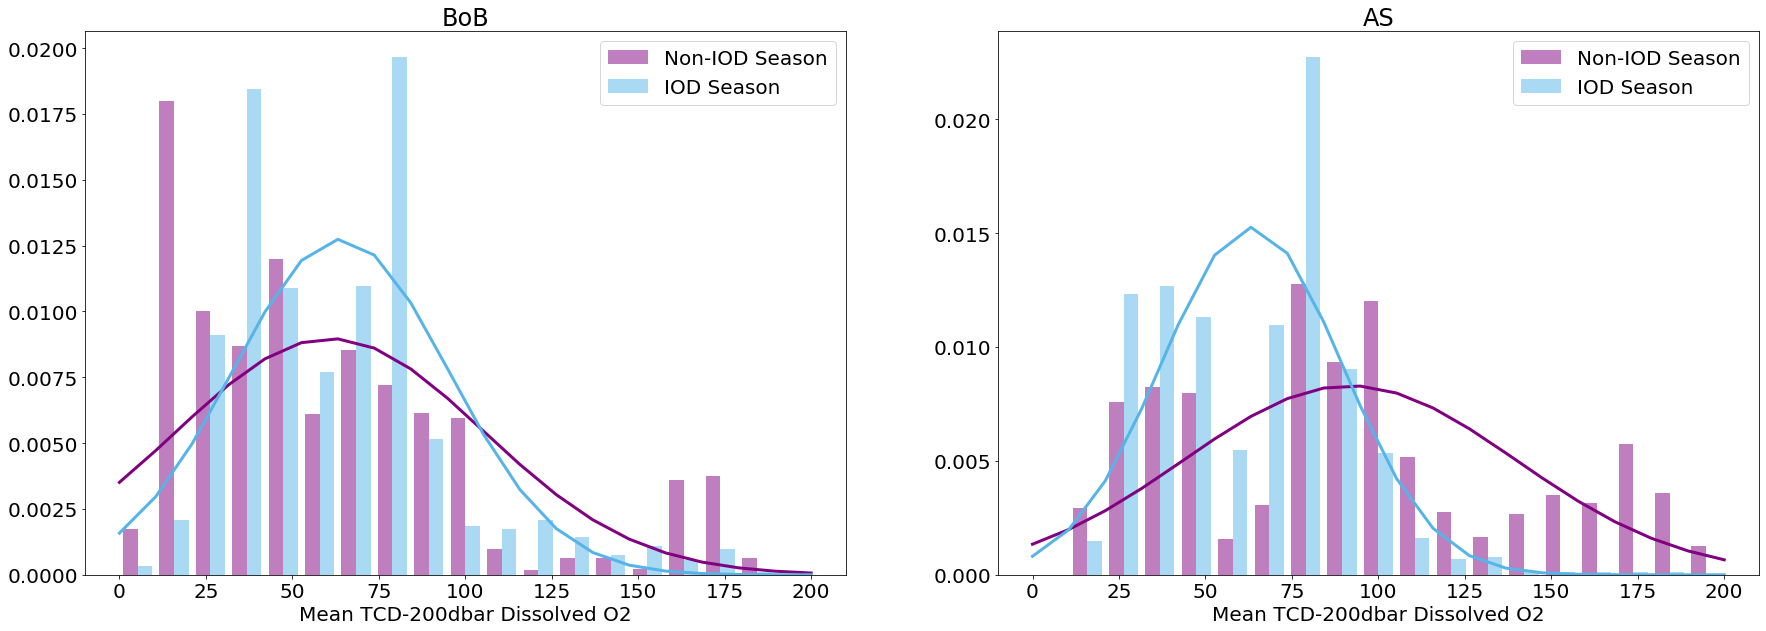

In [25]:
var = ds_CD.doxy_WOA_TCD_200_ave
# ------------------------------------------------------------#
# Bin and Block
# ------------------------------------------------------------#
    
# bin for each month
TCD_WOA_bin_ave,TCD_WOA_bin_vals,TCD_WOA_bncts,latbins,lonbins = latlonbin_season(var,
                                                                                  ds_CD.lat,ds_CD.lon,
                                                                                  ds_CD.IODseason,bounds,binwidth)

        
seas_data = coastal_blocks_IOD_season_WOA(TCD_WOA_bin_vals,sta_loninds,sta_latinds,loc_list)

# ------------------------------------------------------------#
# Plot
# ------------------------------------------------------------#


cnt = 1
seas_title = ['EQ', 'BoB', 'AS']
fig = plt.figure(figsize=(30, 10))
plt.rcParams.update({'font.size': 20})
binedges = np.linspace(0,200,20)
for loc in range(1,3):
    # Make a separate list for each airline
    x1 = list(seas_data[0,loc])
    x2 = list(seas_data[1,loc])

    # Assign colors for each airline and the names
    colors = ['purple','#56B4E9']
    names = ['Non-IOD Season','IOD Season']

    # Make the histogram using a list of lists
    # Normalize the flights and assign colors and names
    ax = fig.add_subplot(1,2,cnt)
    n, bins, patches = plt.hist([x1, x2],bins = binedges,
             density = True,alpha = 0.5,
             color = colors, label=names)
    for ii,x in enumerate([x1,x2]):
        mu = np.nanmean(x)
        sigma = np.nanstd(x)
        y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
         np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
        plt.plot(bins, y, '-',c = colors[ii],linewidth = 3)

    # Plot formatting
    plt.xlabel('Mean TCD-200dbar Dissolved O2')
    plt.legend()
    plt.title(seas_title[loc])
    cnt = cnt + 1

### <font color='lightblue'>Oxygen Anomaly</font> 

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:213: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:213: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:213: RuntimeWarning: Mean of empty slice


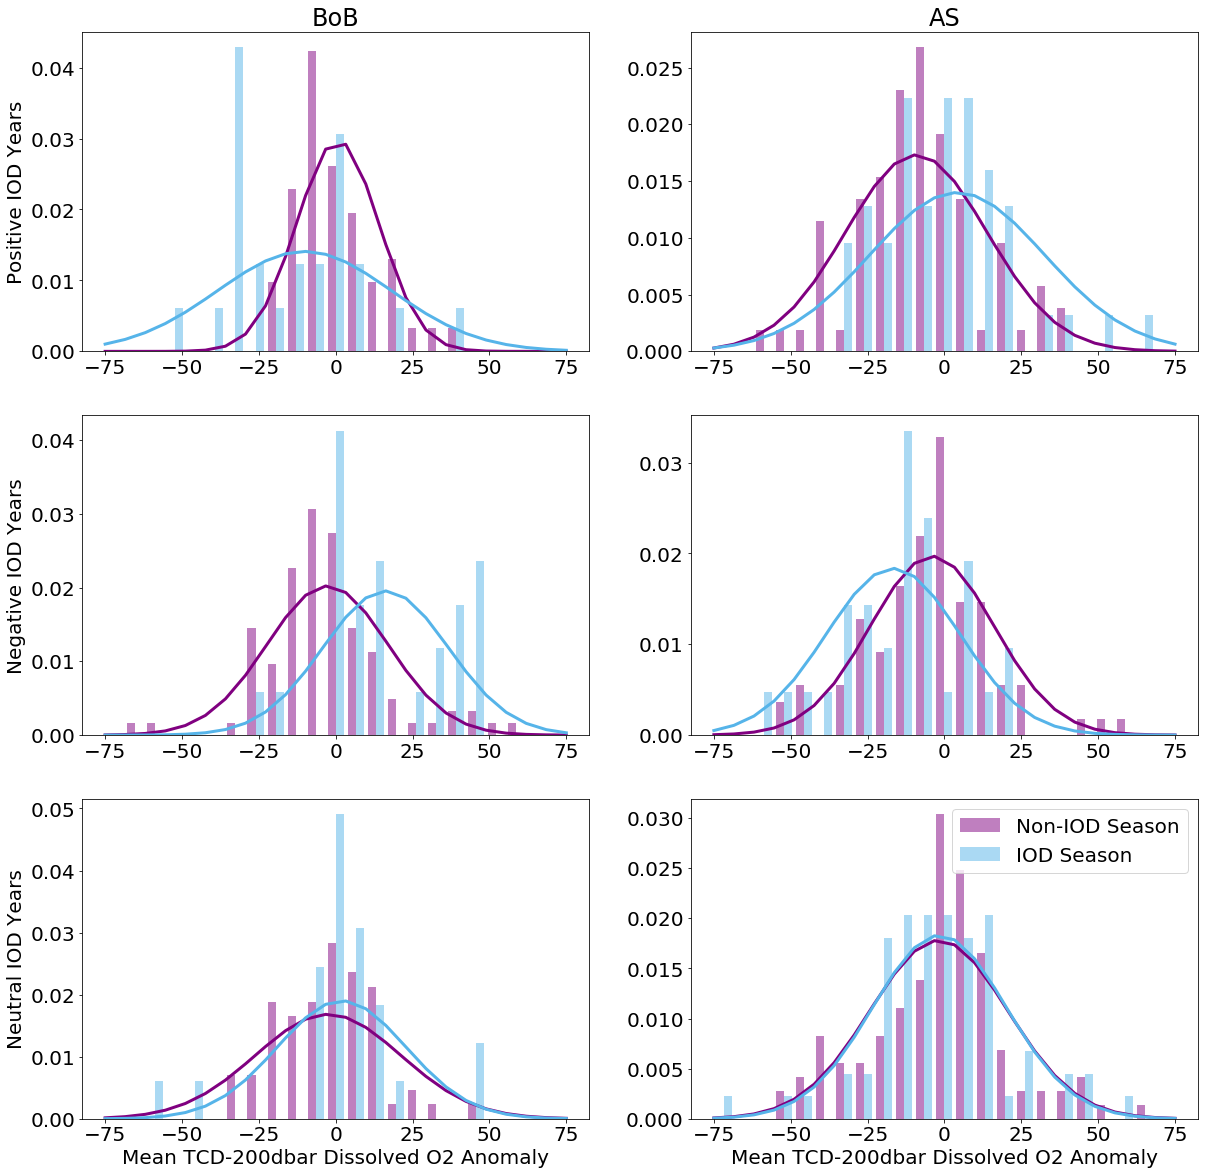

In [26]:
var = ds_CD.doxy_anom_TCD_200_ave
# ------------------------------------------------------------#
# Bin
# ------------------------------------------------------------#
    
# average over the positive IOD years -------------------------------------------# 
posIODdata,posIODlat,posIODlon,posIODtime,posIODseason = IOD_year_group(var,
                                             ds_CD.lat,ds_CD.lon,ds_CD.time,
                                             ds_CD.IODseason,IODyear_begin,IODyear_end,posIODyears)
    
# bin for each month
posIOD_TCD_bin_ave,posIOD_TCD_bin_vals,posIOD_TCD_bncts,latbins,lonbins = latlonbin_season(posIODdata,
                                                                                           posIODlat,posIODlon,
                                                                                           posIODseason,
                                                                                           bounds,binwidth)
# average over the negative IOD years -------------------------------------------# 
negIODdata,negIODlat,negIODlon,negIODtime,negIODseason = IOD_year_group(var,
                                             ds_CD.lat,ds_CD.lon,ds_CD.time,
                                             ds_CD.IODseason,IODyear_begin,IODyear_end,negIODyears)
    
# bin for each month
negIOD_TCD_bin_ave,negIOD_TCD_bin_vals,negIOD_TCD_bncts,latbins,lonbins = latlonbin_season(negIODdata,
                                                                                           negIODlat,negIODlon,
                                                                                           negIODseason,
                                                                                           bounds,binwidth)
# average over the neutral IOD years -------------------------------------------# 
neuIODdata,neuIODlat,neuIODlon,neuIODtime,neuIODseason = IOD_year_group(var,
                                             ds_CD.lat,ds_CD.lon,ds_CD.time,
                                             ds_CD.IODseason,IODyear_begin,IODyear_end,neuIODyears)
    
# bin for each month
neuIOD_TCD_bin_ave,neuIOD_TCD_bin_vals,neuIOD_TCD_bncts,latbins,lonbins = latlonbin_season(neuIODdata,
                                                                                           neuIODlat,neuIODlon,
                                                                                           neuIODseason,
                                                                                           bounds,binwidth)

# ------------------------------------------------------------#
# Block
# ------------------------------------------------------------#
phase_list = [posIOD_TCD_bin_vals,negIOD_TCD_bin_vals,neuIOD_TCD_bin_vals]

phase_data = coastal_block_IOD_season_phase(phase_list,sta_loninds,sta_latinds,loc_list)

# ------------------------------------------------------------#
# Plot
# ------------------------------------------------------------#
cnt = 1
phase_title = ['Positive IOD Years','Negative IOD Years','Neutral IOD Years']
seas_title = ['EQ', 'BoB', 'AS']
fig = plt.figure(figsize=(20, 20))
plt.rcParams.update({'font.size': 20})
binedges = np.linspace(-75,75,24)
for pp in range(3):

    for loc in range(1,3):
        # Make a separate list for each airline
        x1 = list(phase_data[pp][0,loc])
        x2 = list(phase_data[pp][1,loc])

        # Assign colors for each airline and the names
        colors = ['purple', '#56B4E9']
        names = ['Non-IOD Season','IOD Season']

        # Make the histogram using a list of lists
        # Normalize the flights and assign colors and names
        ax = fig.add_subplot(3,2,cnt)
        n, bins, patches = plt.hist([x1, x2],bins = binedges,
                 density = True, alpha = 0.5,
                 color = colors, label=names)
        for ii,x in enumerate([x1,x2]):
            mu = np.nanmean(x)
            sigma = np.nanstd(x)
            y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
             np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
            plt.plot(bins, y, '-',c = colors[ii],linewidth = 3)

        if (cnt == 5) | (cnt ==6):
            plt.xlabel('Mean TCD-200dbar Dissolved O2 Anomaly')
        if (cnt == 1) | (cnt ==3)| (cnt ==5):
            plt.ylabel(phase_title[pp])
#         plt.ylim(0,0.02)
#         plt.xlim(0,200)
        if (cnt == 1) | (cnt ==2):
            plt.title(seas_title[loc])
        if cnt == 6:
            plt.legend()
        cnt = cnt + 1

### <font color='lightblue'>Total Oxygen and WOA</font> 

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:213: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:213: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:213: RuntimeWarning: Mean of empty slice


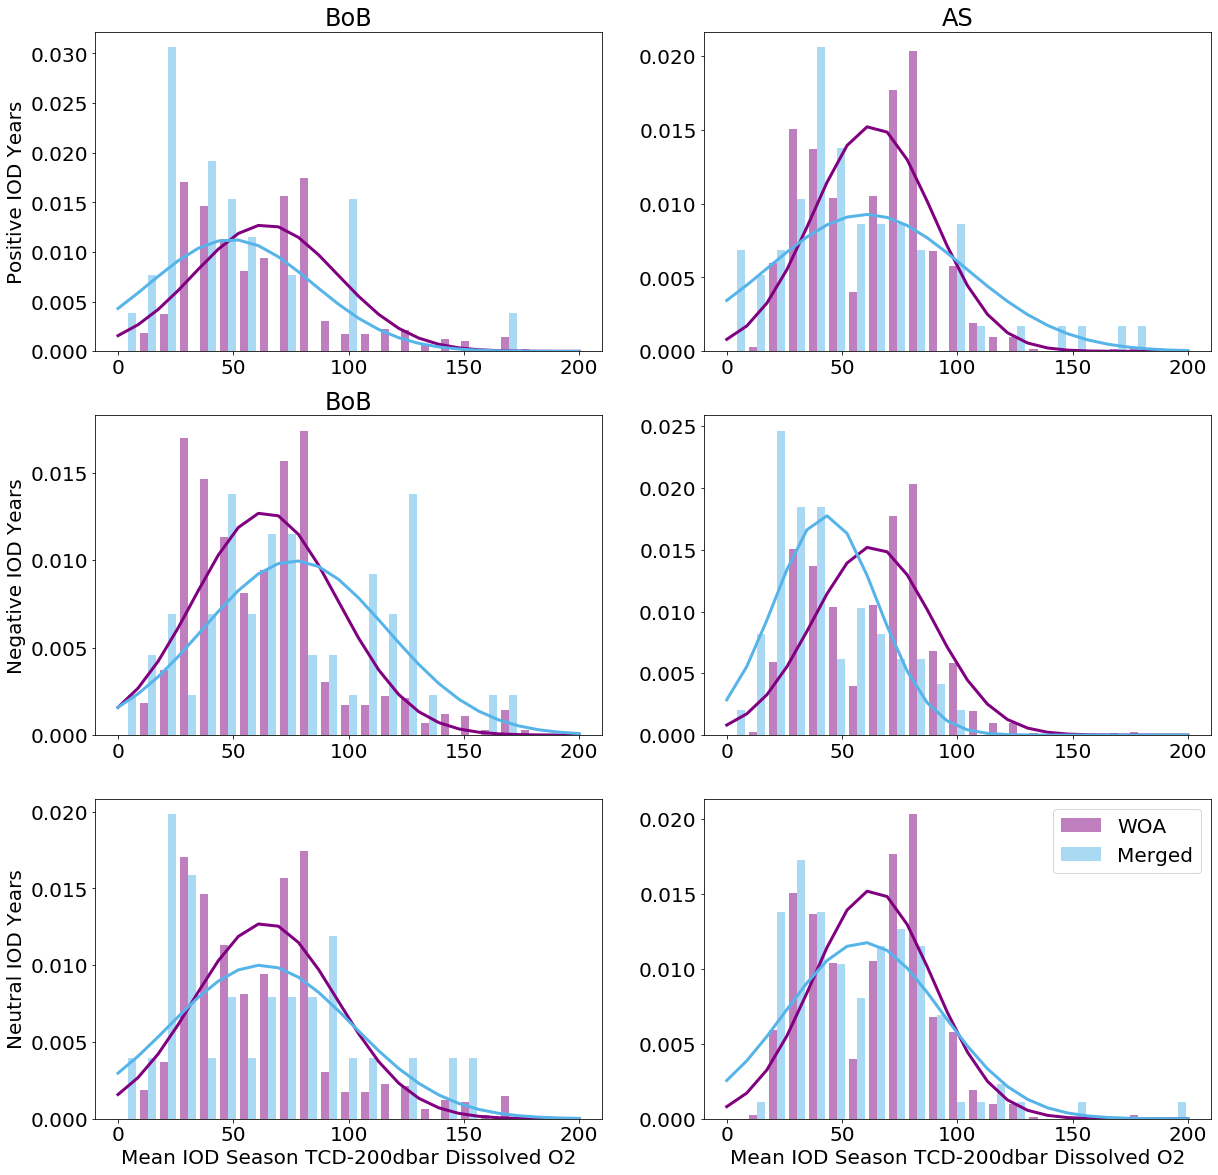

In [27]:
var = ds_CD.doxy_TCD_200_ave
# ------------------------------------------------------------#
# Bin
# ------------------------------------------------------------#
    
# average over the positive IOD years -------------------------------------------# 
posIODdata,posIODlat,posIODlon,posIODtime,posIODseason = IOD_year_group(var,
                                             ds_CD.lat,ds_CD.lon,ds_CD.time,
                                             ds_CD.IODseason,IODyear_begin,IODyear_end,posIODyears)
    
# bin for each month
posIOD_TCD_bin_ave,posIOD_TCD_bin_vals,posIOD_TCD_bncts,latbins,lonbins = latlonbin_season(posIODdata,
                                                                                           posIODlat,posIODlon,
                                                                                           posIODseason,
                                                                                           bounds,binwidth)
# average over the negative IOD years -------------------------------------------# 
negIODdata,negIODlat,negIODlon,negIODtime,negIODseason = IOD_year_group(var,
                                             ds_CD.lat,ds_CD.lon,ds_CD.time,
                                             ds_CD.IODseason,IODyear_begin,IODyear_end,negIODyears)
    
# bin for each month
negIOD_TCD_bin_ave,negIOD_TCD_bin_vals,negIOD_TCD_bncts,latbins,lonbins = latlonbin_season(negIODdata,
                                                                                           negIODlat,negIODlon,
                                                                                           negIODseason,
                                                                                           bounds,binwidth)
# average over the neutral IOD years -------------------------------------------# 
neuIODdata,neuIODlat,neuIODlon,neuIODtime,neuIODseason = IOD_year_group(var,
                                             ds_CD.lat,ds_CD.lon,ds_CD.time,
                                             ds_CD.IODseason,IODyear_begin,IODyear_end,neuIODyears)
    
# bin for each month
neuIOD_TCD_bin_ave,neuIOD_TCD_bin_vals,neuIOD_TCD_bncts,latbins,lonbins = latlonbin_season(neuIODdata,
                                                                                           neuIODlat,neuIODlon,
                                                                                           neuIODseason,
                                                                                           bounds,binwidth)

# ------------------------------------------------------------#
# Block
# ------------------------------------------------------------#
phase_list = [posIOD_TCD_bin_vals,negIOD_TCD_bin_vals,neuIOD_TCD_bin_vals]

phase_data = coastal_block_IOD_season_phase(phase_list,sta_loninds,sta_latinds,loc_list)

# ------------------------------------------------------------#
# Plot
# ------------------------------------------------------------#
cnt = 1
names = ['Positive IOD Years','Negative IOD Years','Neutral IOD Years']
seas_title = ['EQ', 'BoB', 'AS']
fig = plt.figure(figsize=(20, 20))
plt.rcParams.update({'font.size': 20})
binedges = np.linspace(0,200,24)
for pp in range(3):

    for loc in range(1,3):
        # Make a separate list for each airline
        x2 = list(phase_data[pp][1,loc])
        x1 = list(seas_data[1,loc])

        # Assign colors for each airline and the names
        colors = ['purple', '#56B4E9']
        names = ['WOA','Merged']

        # Make the histogram using a list of lists
        # Normalize the flights and assign colors and names
        ax = fig.add_subplot(3,2,cnt)
        n, bins, patches = plt.hist([x1, x2],bins = binedges,
                 density = True,alpha = 0.5,
                 color = colors, label=names)
        for ii,x in enumerate([x1,x2]):
            mu = np.nanmean(x)
            sigma = np.nanstd(x)
            y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
             np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
            plt.plot(bins, y, '-',c = colors[ii],linewidth = 3)


        if (cnt == 5) | (cnt ==6):
            plt.xlabel('Mean IOD Season TCD-200dbar Dissolved O2')
        if (cnt == 1) | (cnt ==3)| (cnt ==5):
            plt.ylabel(phase_title[pp])
        if (cnt == 1) | (cnt ==2)| (cnt ==3):
            plt.title(seas_title[loc])
        if cnt == 6:
            plt.legend()
        cnt = cnt + 1

### <font color='lightblue'>Grouped IOD Year Total Oxygen and WOA During IOD Season</font> 

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:213: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:213: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:213: RuntimeWarning: Mean of empty slice


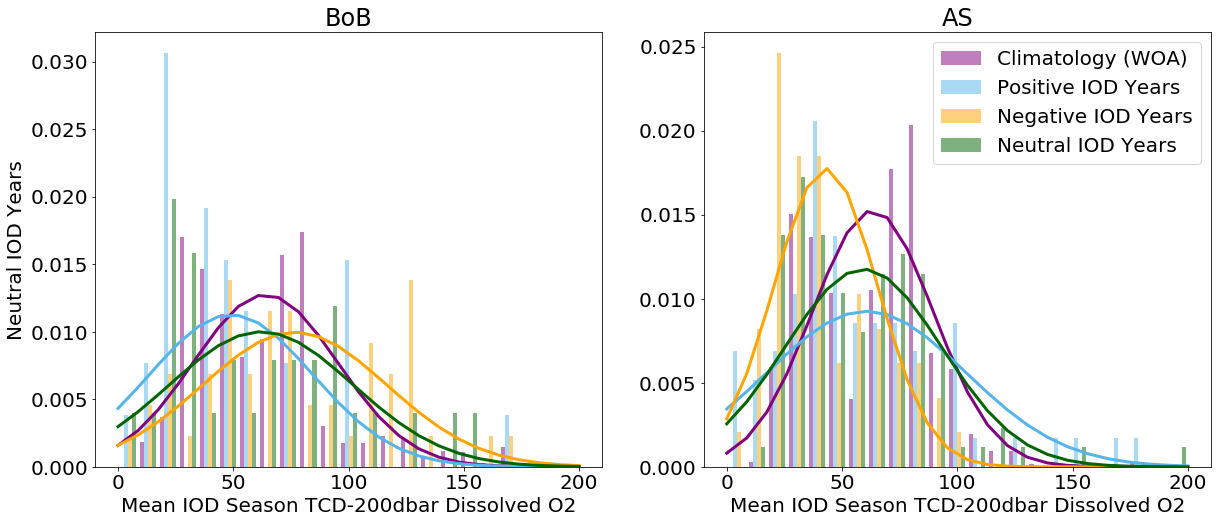

In [18]:

var = ds_CD.doxy_TCD_200_ave
# ------------------------------------------------------------#
# Bin
# ------------------------------------------------------------#
    
# average over the positive IOD years -------------------------------------------# 
posIODdata,posIODlat,posIODlon,posIODtime,posIODseason = IOD_year_group(var,
                                             ds_CD.lat,ds_CD.lon,ds_CD.time,
                                             ds_CD.IODseason,IODyear_begin,IODyear_end,posIODyears)
    
# bin for each month
posIOD_TCD_bin_ave,posIOD_TCD_bin_vals,posIOD_TCD_bncts,latbins,lonbins = latlonbin_season(posIODdata,
                                                                                           posIODlat,posIODlon,
                                                                                           posIODseason,
                                                                                           bounds,binwidth)
# average over the negative IOD years -------------------------------------------# 
negIODdata,negIODlat,negIODlon,negIODtime,negIODseason = IOD_year_group(var,
                                             ds_CD.lat,ds_CD.lon,ds_CD.time,
                                             ds_CD.IODseason,IODyear_begin,IODyear_end,negIODyears)
    
# bin for each month
negIOD_TCD_bin_ave,negIOD_TCD_bin_vals,negIOD_TCD_bncts,latbins,lonbins = latlonbin_season(negIODdata,
                                                                                           negIODlat,negIODlon,
                                                                                           negIODseason,
                                                                                           bounds,binwidth)
# average over the neutral IOD years -------------------------------------------# 
neuIODdata,neuIODlat,neuIODlon,neuIODtime,neuIODseason = IOD_year_group(var,
                                             ds_CD.lat,ds_CD.lon,ds_CD.time,
                                             ds_CD.IODseason,IODyear_begin,IODyear_end,neuIODyears)
    
# bin for each month
neuIOD_TCD_bin_ave,neuIOD_TCD_bin_vals,neuIOD_TCD_bncts,latbins,lonbins = latlonbin_season(neuIODdata,
                                                                                           neuIODlat,neuIODlon,
                                                                                           neuIODseason,
                                                                                           bounds,binwidth)

# ------------------------------------------------------------#
# Block
# ------------------------------------------------------------#
phase_list = [posIOD_TCD_bin_vals,negIOD_TCD_bin_vals,neuIOD_TCD_bin_vals]

phase_data = coastal_block_IOD_season_phase(phase_list,sta_loninds,sta_latinds,loc_list)

# ------------------------------------------------------------#
# Plot
# ------------------------------------------------------------#
cnt = 1
seas_title = ['EQ', 'BoB', 'AS']
fig = plt.figure(figsize=(20, 8))
plt.rcParams.update({'font.size': 20})
binedges = np.linspace(0,200,24)
for loc in range(1,3):
    # Make a separate list for each airline
    x1 = list(seas_data[1,loc])
    x2 = list(phase_data[0][1,loc])
    x3 = list(phase_data[1][1,loc])
    x4 = list(phase_data[2][1,loc])

    # Assign colors for each airline and the names
    colors = ['purple', '#56B4E9','orange','darkgreen']
    names = ['Climatology (WOA)','Positive IOD Years','Negative IOD Years','Neutral IOD Years']

    # Make the histogram using a list of lists
    # Normalize the flights and assign colors and names
    ax = fig.add_subplot(1,2,cnt)
    n, bins, patches = plt.hist([x1,x2,x3,x4],bins = binedges,
             density = True,alpha = 0.5,
             color = colors, label=names)
    for ii,x in enumerate([x1,x2,x3,x4]):
        mu = np.nanmean(x)
        sigma = np.nanstd(x)
        y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
         np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
        plt.plot(bins, y, '-',c = colors[ii],linewidth = 3)
#     for ii,x in enumerate([x1,x2,x3,x4]):
#         n, bins, patches = plt.hist(x,bins = binedges,
#              density = True,
#              alpha = 0,
#              color = 'w')
#         bins=(np.array(bins)[:-1]+np.array(bins)[1:])/2
#         plt.plot(bins, gaussian_filter(n,1), '-',c = colors[ii],linewidth = 3)








    plt.xlabel('Mean IOD Season TCD-200dbar Dissolved O2')
    if (cnt == 1) | (cnt ==3)| (cnt ==5):
        plt.ylabel(phase_title[pp])
    if (cnt == 1) | (cnt ==2):
        plt.title(seas_title[loc])
    if cnt == 2:
        plt.legend()
    cnt = cnt + 1

### <font color='lightblue'>Grouped IOD Year Total Oxygen and WOA During Full Year</font> 

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:213: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:213: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:213: RuntimeWarning: Mean of empty slice


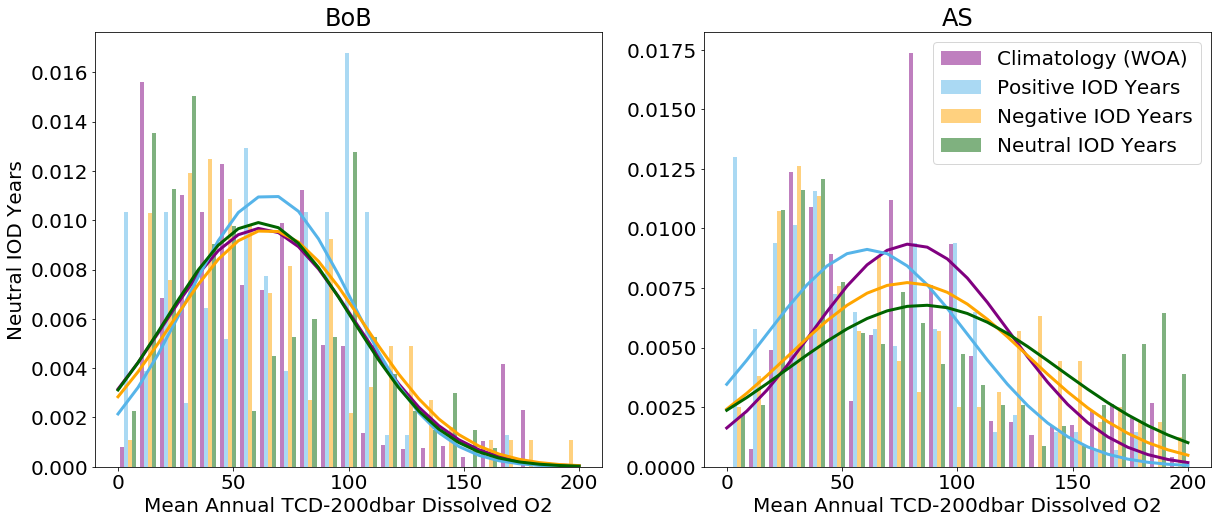

In [19]:
var = ds_CD.doxy_TCD_200_ave
# ------------------------------------------------------------#
# Bin
# ------------------------------------------------------------#
    
# average over the positive IOD years -------------------------------------------# 
posIODdata,posIODlat,posIODlon,posIODtime,posIODseason = IOD_year_group(var,
                                             ds_CD.lat,ds_CD.lon,ds_CD.time,
                                             ds_CD.IODseason,IODyear_begin,IODyear_end,posIODyears)
    
# bin for each month
posIOD_TCD_bin_ave,posIOD_TCD_bin_vals,posIOD_TCD_bncts,latbins,lonbins = latlonbin_season(posIODdata,
                                                                                           posIODlat,posIODlon,
                                                                                           posIODseason,
                                                                                           bounds,binwidth)
# average over the negative IOD years -------------------------------------------# 
negIODdata,negIODlat,negIODlon,negIODtime,negIODseason = IOD_year_group(var,
                                             ds_CD.lat,ds_CD.lon,ds_CD.time,
                                             ds_CD.IODseason,IODyear_begin,IODyear_end,negIODyears)
    
# bin for each month
negIOD_TCD_bin_ave,negIOD_TCD_bin_vals,negIOD_TCD_bncts,latbins,lonbins = latlonbin_season(negIODdata,
                                                                                           negIODlat,negIODlon,
                                                                                           negIODseason,
                                                                                           bounds,binwidth)
# average over the neutral IOD years -------------------------------------------# 
neuIODdata,neuIODlat,neuIODlon,neuIODtime,neuIODseason = IOD_year_group(var,
                                             ds_CD.lat,ds_CD.lon,ds_CD.time,
                                             ds_CD.IODseason,IODyear_begin,IODyear_end,neuIODyears)
    
# bin for each month
neuIOD_TCD_bin_ave,neuIOD_TCD_bin_vals,neuIOD_TCD_bncts,latbins,lonbins = latlonbin_season(neuIODdata,
                                                                                           neuIODlat,neuIODlon,
                                                                                           neuIODseason,
                                                                                           bounds,binwidth)

# ------------------------------------------------------------#
# Block
# ------------------------------------------------------------#
phase_list = [posIOD_TCD_bin_vals,negIOD_TCD_bin_vals,neuIOD_TCD_bin_vals]

phase_data = coastal_block_IOD_season_phase(phase_list,sta_loninds,sta_latinds,loc_list)

# ------------------------------------------------------------#
# Plot
# ------------------------------------------------------------#
cnt = 1
seas_title = ['EQ', 'BoB', 'AS']
fig = plt.figure(figsize=(20, 8))
plt.rcParams.update({'font.size': 20})
binedges = np.linspace(0,200,24)
for loc in range(1,3):
    # Make a separate list for each airline
    x1 = list(np.concatenate((seas_data[0,loc],seas_data[1,loc])))
    x2 = list(np.concatenate((phase_data[0][0,loc],phase_data[0][1,loc])))
    x3 = list(np.concatenate((phase_data[1][0,loc],phase_data[1][1,loc])))
    x4 = list(np.concatenate((phase_data[2][0,loc],phase_data[2][1,loc])))

    # Assign colors for each airline and the names
    colors = ['purple', '#56B4E9','orange','darkgreen']
    names = ['Climatology (WOA)','Positive IOD Years','Negative IOD Years','Neutral IOD Years']

    # Make the histogram using a list of lists
    # Normalize the flights and assign colors and names
    ax = fig.add_subplot(1,2,cnt)
    n, bins, patches = plt.hist([x1,x2,x3,x4],bins = binedges,
             density = True,alpha = 0.5,
             color = colors, label=names)
    for ii,x in enumerate([x1,x2,x3,x4]):
        mu = np.nanmean(x)
        sigma = np.nanstd(x)
        y = ((1 / (np.sqrt(2 * np.pi) * sigma)) *
         np.exp(-0.5 * (1 / sigma * (bins - mu))**2))
        plt.plot(bins, y, '-',c = colors[ii],linewidth = 3)
#     for ii,x in enumerate([x1,x2,x3,x4]):
#         n, bins, patches = plt.hist(x,bins = binedges,
#              density = True,
#              alpha = 0,
#              color = 'w')
#         bins=(np.array(bins)[:-1]+np.array(bins)[1:])/2
#         plt.plot(bins, gaussian_filter(n,1), '-',c = colors[ii],linewidth = 3)



    plt.xlabel('Mean Annual TCD-200dbar Dissolved O2')
    if (cnt == 1) | (cnt ==3)| (cnt ==5):
        plt.ylabel('phase_title[pp]')
    if (cnt == 1) | (cnt ==2):
        plt.title(seas_title[loc])
    if cnt == 2:
        plt.legend()
    cnt = cnt + 1

In [ ]:
# you finished hee

# you were going to try and fix the two figures above, maybe do the seasonal equivalent
#  figure here and save this for the temp and doxy anomalies

# remove the equator part...don't need that.

# maybe there is a statistical test you could do? talk to abbie about a possible way to make the connection?